In [1]:
from __future__ import print_function

from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd

In [2]:
# Create Spark Session
spark = SparkSession.builder \
    .appName("GWU-project1") \
    .master("local[1]") \
    .getOrCreate()


In [3]:
df = spark.read.option("header", "true").option("inferSchema", "true")\
    .csv("data/Life_Expectancy_Data3.csv")

In [4]:
df.show(1)

+-----------+----+----------+----+---------------+-------------+-------+----------------------+----------+-------+----+-----------------+-----+-----------------+----------+--------+---------+-----------+-------------------+------------------+----------------------------+---------+------+
|    Country|Year|    Status|Life|Adult_Mortality|infant_deaths|Alcohol|percentage_expenditure|HepatitisB|Measles| BMI|under-five_deaths|Polio|Total_expenditure|Diphtheria|HIV_AIDS|      GDP| Population|thinness_1-19_years|thinness_5-9_years|Income_composition_resources|Schooling|Region|
+-----------+----+----------+----+---------------+-------------+-------+----------------------+----------+-------+----+-----------------+-----+-----------------+----------+--------+---------+-----------+-------------------+------------------+----------------------------+---------+------+
|Afghanistan|2015|Developing|65.0|            263|           62|   0.01|           71.27962362|        65|   1154|19.1|              

In [5]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Life: double (nullable = true)
 |-- Adult_Mortality: integer (nullable = true)
 |-- infant_deaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- percentage_expenditure: double (nullable = true)
 |-- HepatitisB: integer (nullable = true)
 |-- Measles: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- under-five_deaths: integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Total_expenditure: double (nullable = true)
 |-- Diphtheria: integer (nullable = true)
 |-- HIV_AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- thinness_1-19_years: double (nullable = true)
 |-- thinness_5-9_years: double (nullable = true)
 |-- Income_composition_resources: double (nullable = true)
 |-- Schooling: double (nullable = true)
 |-- Region: string (nullable = true)



In [6]:
#####################################################################################################################
#####################################################################################################################

In [7]:
df.createOrReplaceTempView("life_expectancy_data")

# SQL query to remove rows with any NaN or NULL values in the DataFrame
clean_query = """
SELECT *
FROM life_expectancy_data
WHERE NOT (
    {conditions}
)
"""

# Generate conditions for each column to check for NULL or NaN (for numerical columns)
columns = df.columns
conditions = " OR ".join([f"`{col}` IS NULL OR isnan(`{col}`)" if "double" in str(df.schema[col].dataType) else f"`{col}` IS NULL" for col in columns])

# Complete and run the query
clean_query = clean_query.format(conditions=conditions)
df_clean = spark.sql(clean_query)

# Register the clean DataFrame for further operations
df_clean.createOrReplaceTempView("clean_life_expectancy_data")

# Check and show how many rows remain
df_clean.show()


+-----------+----+----------+----+---------------+-------------+-------+----------------------+----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+-------------------+------------------+----------------------------+---------+------+
|    Country|Year|    Status|Life|Adult_Mortality|infant_deaths|Alcohol|percentage_expenditure|HepatitisB|Measles| BMI|under-five_deaths|Polio|Total_expenditure|Diphtheria|HIV_AIDS|        GDP| Population|thinness_1-19_years|thinness_5-9_years|Income_composition_resources|Schooling|Region|
+-----------+----+----------+----+---------------+-------------+-------+----------------------+----------+-------+----+-----------------+-----+-----------------+----------+--------+-----------+-----------+-------------------+------------------+----------------------------+---------+------+
|Afghanistan|2015|Developing|65.0|            263|           62|   0.01|           71.27962362|        65|   1154|19.1|        

In [8]:
# Register the DataFrame as a temporary view if not already done
df_clean.createOrReplaceTempView("clean_life_expectancy_data")

# Generate conditions for checking NaN or NULL in each column
columns = df_clean.columns
conditions = " OR ".join([f"`{col}` IS NULL OR isnan(`{col}`)" if "double" in str(df.schema[col].dataType) else f"`{col}` IS NULL" for col in columns])

# SQL query to count rows that have any NaN or NULL values
nan_null_count_query = f"""
SELECT COUNT(*) AS count_nan_null_rows
FROM clean_life_expectancy_data
WHERE {conditions}
"""

# Execute the query
nan_null_counts = spark.sql(nan_null_count_query)

# Show the result
nan_null_counts.show()


+-------------------+
|count_nan_null_rows|
+-------------------+
|                  0|
+-------------------+



In [9]:
# Register the cleaned DataFrame as a temporary view
df_clean.createOrReplaceTempView("clean_life_expectancy_data")

# Check the minimum and maximum of Life expectancy to decide bin ranges
spark.sql("SELECT MIN(`Life`), MAX(`Life`) FROM clean_life_expectancy_data").show()



+---------+---------+
|min(Life)|max(Life)|
+---------+---------+
|     44.0|     89.0|
+---------+---------+



In [10]:
# SQL query to create histogram data for the "Life" feature with an additional category for outliers or NULLs
histogram_query = """
SELECT 
    CASE
        WHEN FLOOR(`Life`) BETWEEN 44 AND 49 THEN '44-49'
        WHEN FLOOR(`Life`) BETWEEN 50 AND 54 THEN '50-54'
        WHEN FLOOR(`Life`) BETWEEN 55 AND 59 THEN '55-59'
        WHEN FLOOR(`Life`) BETWEEN 60 AND 64 THEN '60-64'
        WHEN FLOOR(`Life`) BETWEEN 65 AND 69 THEN '65-69'
        WHEN FLOOR(`Life`) BETWEEN 70 AND 74 THEN '70-74'
        WHEN FLOOR(`Life`) BETWEEN 75 AND 79 THEN '75-79'
        WHEN FLOOR(`Life`) BETWEEN 80 AND 84 THEN '80-84'
        WHEN FLOOR(`Life`) BETWEEN 85 AND 89 THEN '85-89'
        ELSE 'Out of Range or NULL' END AS `Life_Expectancy_Range`,
    COUNT(*) AS `Count`
FROM 
    clean_life_expectancy_data
GROUP BY 
    `Life_Expectancy_Range`
ORDER BY 
    `Life_Expectancy_Range`
"""

# Execute the SQL query
histogram_data = spark.sql(histogram_query)

# Show the results
histogram_data.show(truncate=False)


+---------------------+-----+
|Life_Expectancy_Range|Count|
+---------------------+-----+
|44-49                |56   |
|50-54                |75   |
|55-59                |156  |
|60-64                |152  |
|65-69                |315  |
|70-74                |480  |
|75-79                |286  |
|80-84                |100  |
|85-89                |29   |
+---------------------+-----+



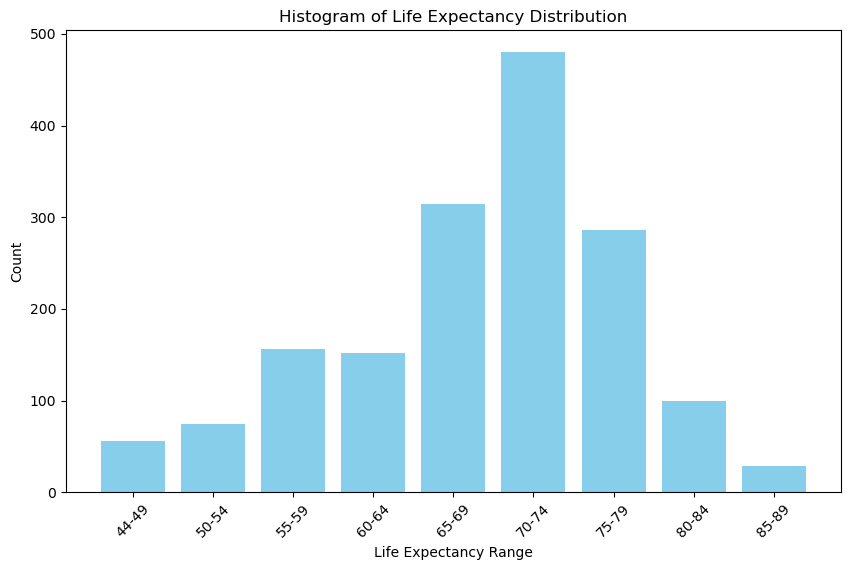

In [11]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
histogram_data_pd = histogram_data.toPandas()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(histogram_data_pd['Life_Expectancy_Range'], histogram_data_pd['Count'], color='skyblue')
plt.xlabel('Life Expectancy Range')
plt.ylabel('Count')
plt.title('Histogram of Life Expectancy Distribution')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(False)  # Add a grid for easier visualization
plt.show()


D:\ComputerCode\JF_Environments\spark-env\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

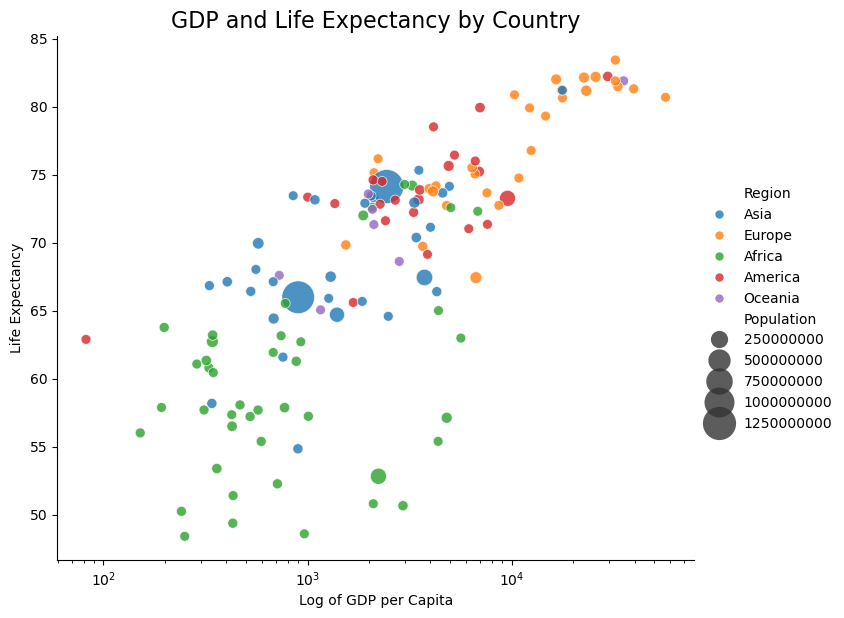

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df_clean.toPandas()

# Group by "Country" and "Region", and calculate the mean of "GDP", "Life expectancy", and "Population"
df_country = df_pandas.groupby(["Country", "Region"])[["GDP", "Life", "Population"]].mean()

# Drop rows with NaN values and reset index
df_country = df_country.dropna().reset_index()

# Set the plot size
plt.figure(figsize=(12, 8))

# Create a scatter plot
g = sns.relplot(x="GDP", y="Life", size="Population", sizes=(50, 600),
                data=df_country, height=6, aspect=1.2, alpha=0.8, hue="Region")

# Setting the x-axis to logarithmic scale
plt.xscale("log")

# Adding title and labels
plt.title('GDP and Life Expectancy by Country', fontsize=16)
plt.xlabel('Log of GDP per Capita')
plt.ylabel('Life Expectancy')

# Display the plot
plt.show()


In [13]:
from pyspark.ml.feature import StringIndexer

# Assuming 'Region' is the column to be indexed
indexer = StringIndexer(inputCol="Region", outputCol="RegionCode")
df_clean = indexer.fit(df_clean).transform(df_clean)

from pyspark.ml.feature import VectorAssembler

# Drop unnecessary columns
columns_to_drop = ["Country", "Status", "Region"]
df_clean = df_clean.drop(*columns_to_drop)

# Assuming all remaining columns are relevant for PCA and are numerical
features = [col for col in df_clean.columns if col != 'RegionCode']

# Create a features vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_clean = assembler.transform(df_clean)


In [14]:
from pyspark.ml.feature import StandardScaler

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(df_clean)
df_clean = scalerModel.transform(df_clean)

from pyspark.ml.feature import PCA

# Apply PCA
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(df_clean)
result = model.transform(df_clean)

# Project the data to principal components
pca_result = result.select("pcaFeatures")
pca_result.show(truncate=False)


+-----------------------------------------+
|pcaFeatures                              |
+-----------------------------------------+
|[3.8395727595073477,-0.15080235606116604]|
|[3.7032274810213415,-0.27789282864654613]|
|[3.731604742318202,-0.1722384505847602]  |
|[3.7337493044261767,-0.16278834055760663]|
|[3.890647017864388,-0.1770727068354211]  |
|[3.9457083365782557,-0.23243832217630994]|
|[4.137999378416501,-0.2322650396115314]  |
|[4.271032633248382,-0.27038460498897293] |
|[4.545689882385221,-0.24788562865729147] |
|[4.681831596675673,-0.33088343184207936] |
|[4.665408175343564,-0.39300775747280353] |
|[5.748389246528215,-0.6401684095571496]  |
|[5.252964570855081,-0.5657945570042286]  |
|[3.948546116100181,-0.43673662128570595] |
|[3.531916550109585,-1.215531266051514]   |
|[3.7596819071189898,-1.3922252536910846] |
|[-2.2169442956585748,0.09799094076005867]|
|[-2.284545045295872,0.2010903308325915]  |
|[-2.1330265952180194,0.07544251707678598]|
|[-2.1041198626772064,0.05688755

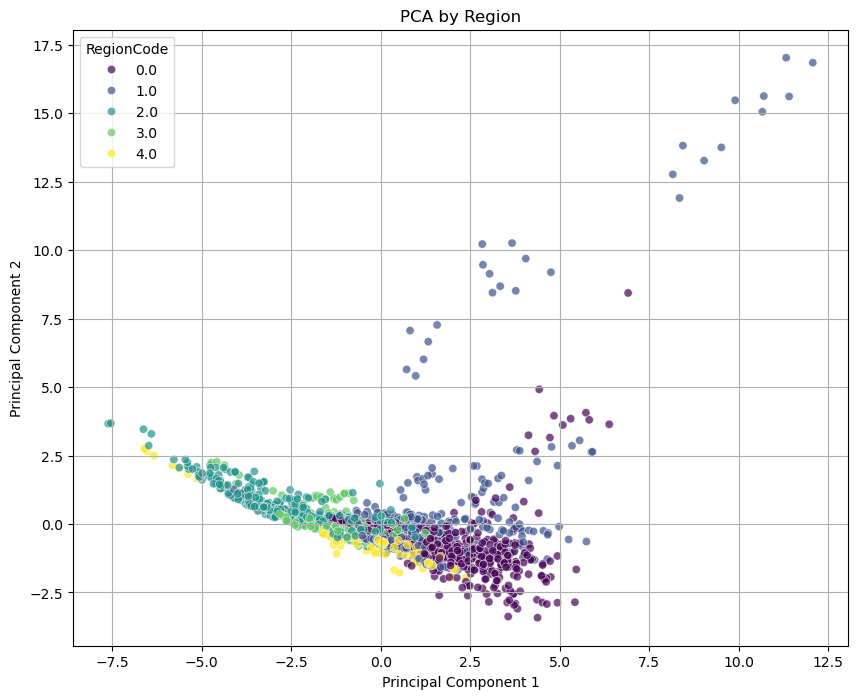

In [15]:
# Assuming 'RegionCode' is still in the Spark DataFrame 'result'
full_pca_result_pd = result.select("pcaFeatures", "RegionCode").toPandas()
full_pca_result_pd['PCA1'] = full_pca_result_pd['pcaFeatures'].apply(lambda x: x[0])
full_pca_result_pd['PCA2'] = full_pca_result_pd['pcaFeatures'].apply(lambda x: x[1])

# Now plot with color coding
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='RegionCode', palette='viridis', data=full_pca_result_pd, alpha=0.7)
plt.title('PCA by Region')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [16]:
##################################################################################################################
##################################################################################################################

In [20]:
df = spark.read.option("header", "true").option("inferSchema", "true")\
    .csv("data/Life_Expectancy_Data3.csv")

In [22]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Life: double (nullable = true)
 |-- Adult_Mortality: integer (nullable = true)
 |-- infant_deaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- percentage_expenditure: double (nullable = true)
 |-- HepatitisB: integer (nullable = true)
 |-- Measles: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- under-five_deaths: integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Total_expenditure: double (nullable = true)
 |-- Diphtheria: integer (nullable = true)
 |-- HIV_AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- thinness_1-19_years: double (nullable = true)
 |-- thinness_5-9_years: double (nullable = true)
 |-- Income_composition_resources: double (nullable = true)
 |-- Schooling: double (nullable = true)
 |-- Region: string (nullable = true)



In [23]:
# Cleaning the Dataset REMOVE Two Columns
df = df.drop(*['Year','Country'])             # dropping some irrelevant columns


In [24]:
# IMPUTER
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=df.drop('Status','Region').columns,
                 outputCols=["{}".format(c) for c in df.drop('Status','Region').columns]).setStrategy('mean')

# add imputation to cols
df_imputed = imputer.fit(df).transform(df)

In [25]:
df_imputed.columns

['Status',
 'Life',
 'Adult_Mortality',
 'infant_deaths',
 'Alcohol',
 'percentage_expenditure',
 'HepatitisB',
 'Measles',
 'BMI',
 'under-five_deaths',
 'Polio',
 'Total_expenditure',
 'Diphtheria',
 'HIV_AIDS',
 'GDP',
 'Population',
 'thinness_1-19_years',
 'thinness_5-9_years',
 'Income_composition_resources',
 'Schooling',
 'Region']

In [26]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
df_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_imputed.columns]
   ).show()

+------+----+---------------+-------------+-------+----------------------+----------+-------+---+-----------------+-----+-----------------+----------+--------+---+----------+-------------------+------------------+----------------------------+---------+------+
|Status|Life|Adult_Mortality|infant_deaths|Alcohol|percentage_expenditure|HepatitisB|Measles|BMI|under-five_deaths|Polio|Total_expenditure|Diphtheria|HIV_AIDS|GDP|Population|thinness_1-19_years|thinness_5-9_years|Income_composition_resources|Schooling|Region|
+------+----+---------------+-------------+-------+----------------------+----------+-------+---+-----------------+-----+-----------------+----------+--------+---+----------+-------------------+------------------+----------------------------+---------+------+
|     0|   0|              0|            0|      0|                     0|         0|      0|  0|                0|    0|                0|         0|       0|  0|         0|                  0|                 0|       

In [27]:
#One hot enconde Status and Region

# First we index it
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols=['Region','Status'], outputCols=['Region_Numeric','Status_Numeric'])
indexer_fitted = indexer.fit(df_imputed)
df_indexed = indexer_fitted.transform(df_imputed)

#now we can one hot encode
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=['Region_Numeric','Status_Numeric'], outputCols=['Region_onehot','Status_onehot'])
df_onehot = encoder.fit(df_indexed).transform(df_indexed)

#Remobe the categorical columns not needed anymore
df_onehot = df_onehot.drop(*['Status','Region','Region_Numeric','Status_Nhmeric'])
df_onehot.columns

['Life',
 'Adult_Mortality',
 'infant_deaths',
 'Alcohol',
 'percentage_expenditure',
 'HepatitisB',
 'Measles',
 'BMI',
 'under-five_deaths',
 'Polio',
 'Total_expenditure',
 'Diphtheria',
 'HIV_AIDS',
 'GDP',
 'Population',
 'thinness_1-19_years',
 'thinness_5-9_years',
 'Income_composition_resources',
 'Schooling',
 'Status_Numeric',
 'Region_onehot',
 'Status_onehot']

In [28]:
df_onehot.printSchema()

root
 |-- Life: double (nullable = true)
 |-- Adult_Mortality: integer (nullable = true)
 |-- infant_deaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- percentage_expenditure: double (nullable = true)
 |-- HepatitisB: integer (nullable = true)
 |-- Measles: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- under-five_deaths: integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Total_expenditure: double (nullable = true)
 |-- Diphtheria: integer (nullable = true)
 |-- HIV_AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- thinness_1-19_years: double (nullable = true)
 |-- thinness_5-9_years: double (nullable = true)
 |-- Income_composition_resources: double (nullable = true)
 |-- Schooling: double (nullable = true)
 |-- Status_Numeric: double (nullable = false)
 |-- Region_onehot: vector (nullable = true)
 |-- Status_onehot: vector (nullable = true)



In [29]:
input_cols = df_onehot.drop('Life').columns

In [30]:
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

df_transform = assembler.transform(df_onehot).select("Life", "features")

In [31]:
df_transform.show(5)

+----+--------------------+
|Life|            features|
+----+--------------------+
|65.0|[263.0,62.0,0.01,...|
|59.9|[271.0,64.0,0.01,...|
|59.9|[268.0,66.0,0.01,...|
|59.5|[272.0,69.0,0.01,...|
|59.2|[275.0,71.0,0.01,...|
+----+--------------------+
only showing top 5 rows



In [32]:
from pyspark.ml.feature import Normalizer, StandardScaler

scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

df_scaled = scaler.fit(df_transform).transform(df_transform)

In [33]:
df_scaled.show(5)

+----+--------------------+--------------------+
|Life|            features|     scaled_features|
+----+--------------------+--------------------+
|65.0|[263.0,62.0,0.01,...|[2.11959495798077...|
|59.9|[271.0,64.0,0.01,...|[2.18406932932619...|
|59.9|[268.0,66.0,0.01,...|[2.15989144007166...|
|59.5|[272.0,69.0,0.01,...|[2.19212862574437...|
|59.2|[275.0,71.0,0.01,...|[2.21630651499890...|
+----+--------------------+--------------------+
only showing top 5 rows



In [34]:
# Let's split our data into training data and testing data
train,test = df_scaled.randomSplit([0.8,0.2])

In [35]:
##############################################################

lr_model = LinearRegression(featuresCol='scaled_features', labelCol='Life')
lr_fitted = lr_model.fit(train)

In [36]:
trainingSummary = lr_fitted.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 3.752460
r2: 0.844372


In [37]:
# Now create our decision tree
dtr = DecisionTreeRegressor().setFeaturesCol("scaled_features").setLabelCol("Life")

# Train the model using our training data
tree_model = dtr.fit(train)

In [38]:
# Now see if we can predict values in our test data.
# Generate predictions using our decision tree model for all features in our
# test dataframe:
fullPredictions = tree_model.transform(test).cache()

In [39]:
fullPredictions.show()

+----+--------------------+--------------------+-----------------+
|Life|            features|     scaled_features|       prediction|
+----+--------------------+--------------------+-----------------+
|41.5|[57.0,30.0,4.07,3...|[0.45937989583613...|52.28985507246377|
|44.5|[675.0,5.0,2.67,5...|[5.44002508227004...|46.52058823529413|
|44.6|[717.0,28.0,4.14,...|[5.77851553183350...|46.52058823529413|
|44.8|[666.0,5.0,1.8,67...|[5.36749141450643...|46.52058823529413|
|45.6|[54.0,17.0,1.52,3...|[0.43520200658160...|52.28985507246377|
|45.9|[511.0,17.0,1.5,4...|[4.11830046968887...|46.52058823529413|
|46.0|[49.0,16.0,1.51,3...|[0.39490552449071...|52.28985507246377|
|46.0|[66.0,39.0,1.04,5...|[0.53191356359973...|52.28985507246377|
|46.6|[554.0,116.0,10.4...|[4.46485021567052...|46.52058823529413|
|46.7|[679.0,2.0,5.48,3...|[5.47226226794275...|51.08947368421053|
|47.6|[44.0,41.0,0.25,2...|[0.35460904239982...|52.28985507246377|
|47.7|[539.0,115.0,10.5...|[4.34396076939785...|46.52058823529

In [40]:
dt_evaluator = RegressionEvaluator(labelCol="Life", predictionCol="prediction", metricName="r2")

rmse = dt_evaluator.evaluate(fullPredictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.889103


In [41]:
lr=LinearRegression(featuresCol='scaled_features', labelCol='Life')

In [42]:
pipeline1=Pipeline(stages=[lr])

In [43]:
paramgrid =ParamGridBuilder()\
.addGrid(lr.regParam, [0, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0])\
.addGrid(lr.maxIter, [10])\
.build()


evaluator=RegressionEvaluator(metricName="r2").setLabelCol("Life")


crossval= CrossValidator(estimator=pipeline1,  
                         estimatorParamMaps=paramgrid,
                         evaluator = evaluator, 
                         numFolds=5
                        )

cvModel1=crossval.fit(train) 
evaluator.evaluate(cvModel1.transform(test))


0.8310453547391342

In [44]:
cvModel1.getEstimatorParamMaps()[ np.argmax(cvModel1.avgMetrics) ]

{Param(parent='LinearRegression_bd503a0724d8', name='regParam', doc='regularization parameter (>= 0).'): 0.001,
 Param(parent='LinearRegression_bd503a0724d8', name='maxIter', doc='max number of iterations (>= 0).'): 10}

In [45]:
cvModel1.avgMetrics

[0.8362089047078415,
 0.8377093853866053,
 0.8375213028285398,
 0.836685783319548,
 0.8364310629096764,
 0.8358540114515473,
 0.8336102230595838]

In [ ]:
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='Life')
pipeline2 = Pipeline(stages=[rf])

paramgrid =ParamGridBuilder()\
.addGrid(rf.numTrees, [200, 500])\
.addGrid(rf.maxDepth, [5,10])\
.build()


evaluator=RegressionEvaluator(metricName="r2").setLabelCol("Life")


crossval= CrossValidator(estimator=pipeline2,  
                         estimatorParamMaps=paramgrid,
                         evaluator = evaluator, 
                         numFolds=5
                        )

cvModel2=crossval.fit(train) 

evaluator.evaluate(cvModel2.transform(test))


In [ ]:
cvModel2.getEstimatorParamMaps()[ np.argmax(cvModel2.avgMetrics) ]

In [ ]:
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='Life')
pipeline3 = Pipeline(stages=[gbt])

paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [2, 5, 10])\
  .addGrid(gbt.maxIter, [10,100,500])\
  .build()

evaluator=RegressionEvaluator(metricName="r2").setLabelCol("Life")


crossval= CrossValidator(estimator=pipeline3,  
                         estimatorParamMaps=paramgrid,
                         evaluator = evaluator, 
                         numFolds=5
                        )

cvModel3=crossval.fit(train) 

evaluator.evaluate(cvModel3.transform(test)